In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow


In [7]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications import VGG19, ResNet50, InceptionV3

In [8]:
# base_path = 'Dataset/flowers/'
base_path = 'C:\\Users\\<user here>\\python\\flowers_keras\\flowers\\'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [9]:
#read in all the paths of the files
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = []
    #full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    for file_name in file_names:
        full_path.append(os.path.join(flower_folder, file_name))
    
    fnames.append(full_path)

In [10]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [769, 1055, 784, 734, 984]


In [11]:
#read all images in using opencv. Will be a pretty big freaking list
images = []
for names in fnames:
    #one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    #images.append(one_category_images)
    image_for_cat = []
    for name in names:
        if cv2.imread(name) is not None:
            image_for_cat.append(cv2.imread(name))
    images.append(image_for_cat)

In [12]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [769, 1052, 784, 734, 984]


In [13]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


In [14]:
#Create a function to convert cv2 BGR format to RGB for showing
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)


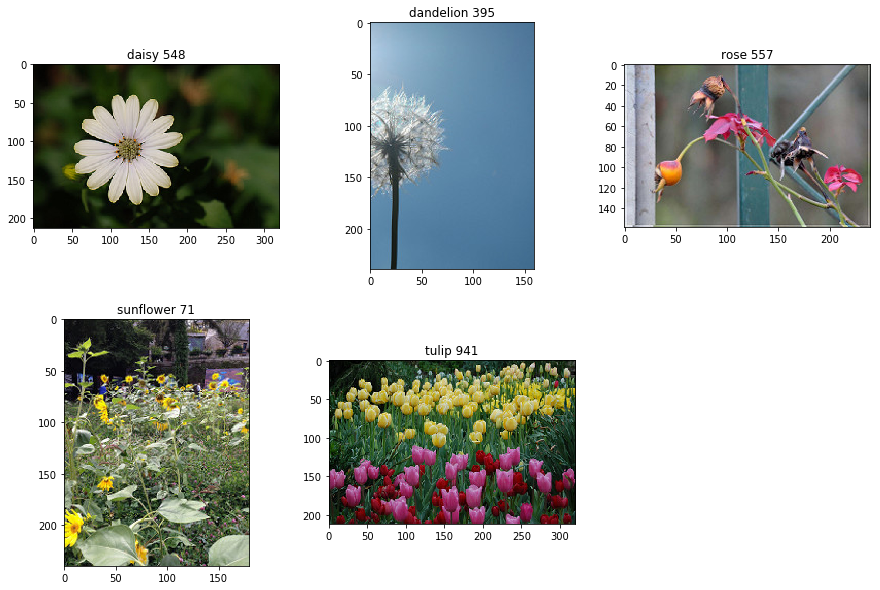

In [15]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid(False)
    plt.title(categories[i]+' '+str(idx))
plt.show()

In [ ]:
#Resize some of the images to 256x256 to test things out a bit
img_width, img_height = 256, 256

img = images[3][659]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [17]:
# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [18]:
#Split dataset to 80% of training and 20% of validation
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)
#val_images and #train_images still has a length of 5 (for each flower category) with each flower in each of those lists

In [19]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8') #(3457, uint8)
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
        #train_categories[:615] = 0
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        #itr 1: train_categories[615:(615+841)] = 1
        #itr 2: train_categories[841:(841+627)] = 2
        #...
        

        
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
        #val_categories[:154] = 0
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i
        #itr 1: val_categories[154:(154+211)] = 1
        #itr 2: val_categories[211:(211+157)] = 2
        #...
        
        
#print(train_categories[:1000])
#0 0 0 0 ... 1 1 1 1 1
#The code here does what you think it does. Hopefully it becomes apparent why later on

[615, 841, 627, 587, 787]
sum of train images: 3457
[154, 211, 157, 147, 197]
sum of val_images: 866


In [20]:
#Convert image data to numpy array
#Convert and pre-processing
#convert class labels to binary class labels

tmp_train_imgs = []
tmp_val_imgs = []

for imgs in train_images:
    tmp_train_imgs += imgs #same as append
for imgs in val_images:
    tmp_val_imgs += imgs #same as append
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)



In [21]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (3457, 256, 256, 3)
train labels: (3457,)

After converting
train data: (3457, 256, 256, 3)
train labels: (3457, 5)


In [22]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [23]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 256, 256, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 256, 256, 3)
shape of val labels: (860, 5)


In [83]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

In [24]:
def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights=None))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

In [26]:
# Parameters
batch_size = 32
epochs1 = 50
epochs2 = 10
epochs3 = 30


# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
    #preprocessing_function #check here what to use it for https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
)



# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
    #class_model #check here for details about class model https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [ ]:
#train from scratch
start = time.time()

model_scratch_info = model_scratch.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_scratch took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs1) )

Epoch 1/50


In [27]:
#train using resnet
start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs3, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )

Epoch 1/30


KeyboardInterrupt: 

In [30]:
#start with prediction and evaluation here
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

In [31]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

In [33]:
plot_model_history('model_scratch', model_scratch_info.history, epochs1)
plot_model_history('model_VGG19', model_VGG19_info.history, epochs2)
plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs3)

NameError: name 'model_ResNet50_info' is not defined

In [29]:
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [34]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('drive/My Drive/AI/Dataset/test_images/rose1.jpg')
pred, probability = predict_one_image(test_img, model_ResNet50)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

error: OpenCV(4.1.0) C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [35]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

Model trained from ResNet-50


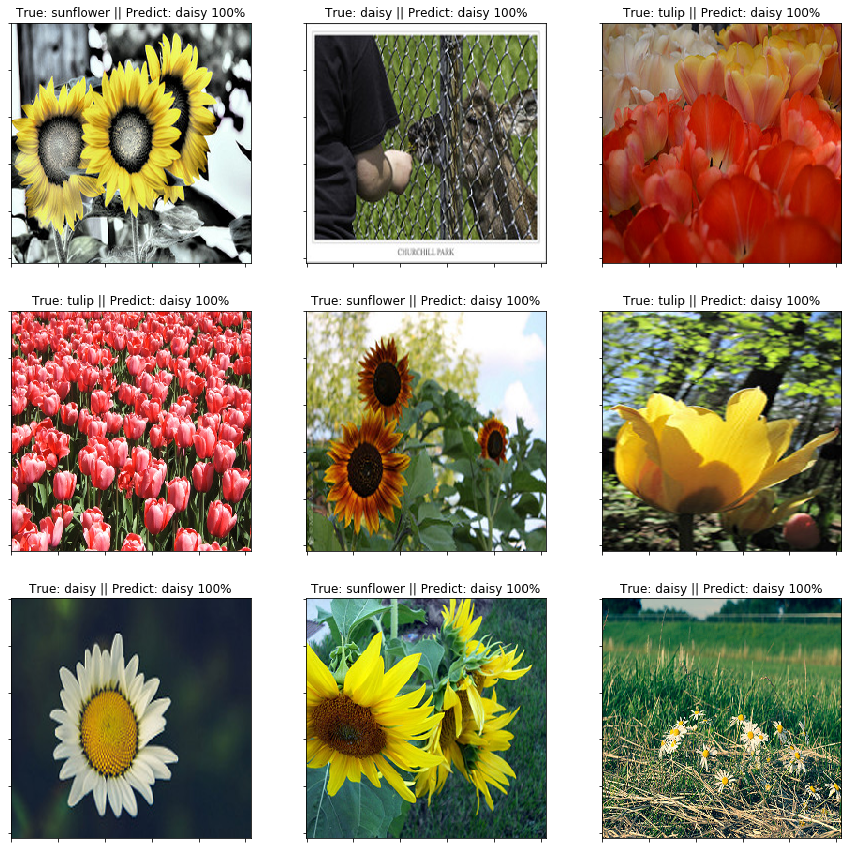

In [36]:
print("Model trained from ResNet-50")
plt.figure(figsize=(15,15))
for i in range(9):
  
  idx = np.random.randint(860)
  
  ax = plt.subplot(3,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], model_ResNet50)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
my_model.save('drive/My Drive/AI/My_Model/flowers_classification_pretrained_by_resnet50_acc_92.h5')